# BERT Tutorial- How To Build a Question Answering Bot

Article by Michel Kana: https://towardsdatascience.com/bert-nlp-how-to-build-a-question-answering-bot-98b1d1594d7b

Code credits to Michel Kana, and Prachur Bhargava, Lead Data Scientist @ Microsoft

In [1]:
# verify GPU availability
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
# install huggingface libraries
!pip install pytorch-pretrained-bert pytorch-nlp pytorch_transformers

In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer, BertConfig, BertModel
from pytorch_transformers import AdamW, BertForQuestionAnswering
from tqdm import tqdm, trange
import pandas as pd
import io
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [6]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [7]:
!ls /drive/My\ Drive/END3

cache_train	  checkpoint-4000  checkpoint-9000	   predictions.json
cache_validation  checkpoint-5000  checkpoint-final	   train-v2.0.json
checkpoint-1000   checkpoint-6000  dev-v2.0.json
checkpoint-2000   checkpoint-7000  nbest_predictions.json
checkpoint-3000   checkpoint-8000  null_odds.json


In [8]:
import sys
sys.path.append('/drive/My Drive/END3')

In [9]:
!wget 'https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad_evaluate.py'

--2022-01-26 02:46:45--  https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad_evaluate.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12493 (12K) [text/plain]
Saving to: ‘utils_squad_evaluate.py’

utils_squad_evaluat 100%[===================>]  12.20K  --.-KB/s    in 0s      

2022-01-26 02:46:46 (93.7 MB/s) - ‘utils_squad_evaluate.py’ saved [12493/12493]



In [10]:
!wget 'https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad.py'

--2022-01-26 02:46:46--  https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41529 (41K) [text/plain]
Saving to: ‘utils_squad.py’

utils_squad.py      100%[===================>]  40.56K  --.-KB/s    in 0.003s  

2022-01-26 02:46:46 (11.6 MB/s) - ‘utils_squad.py’ saved [41529/41529]



In [11]:
!wget 'https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json'

--2022-01-26 02:46:51--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.110.153, 185.199.108.153, 185.199.109.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42123633 (40M) [application/json]
Saving to: ‘train-v2.0.json’

train-v2.0.json     100%[===================>]  40.17M   201MB/s    in 0.2s    

2022-01-26 02:46:51 (201 MB/s) - ‘train-v2.0.json’ saved [42123633/42123633]



In [12]:
from utils_squad import (read_squad_examples, convert_examples_to_features,
                         RawResult, write_predictions,
                         RawResultExtended, write_predictions_extended)
from utils_squad_evaluate import EVAL_OPTS, main as evaluate_on_squad, plot_pr_curve

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [14]:

input_file = '/content/train-v2.0.json'
examples = read_squad_examples(input_file=input_file,
                                is_training=True,
                                version_2_with_negative=True)

In [15]:
examples[:5]  

[qas_id: 56be85543aeaaa14008c9063, question_text: When did Beyonce start becoming popular?, doc_tokens: [Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".], start_position: 39, end_position: 42,
 qas_id: 56be85543aeaaa14008c9065, question_text: What areas did Beyonce compete in when she was growing up?, doc_tokens: [Beyoncé Giselle Knowles-Carter (/biːˈ

In [16]:
train_data = pd.DataFrame.from_records([vars(example) for example in examples])
train_data.head() 

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible
0,56be85543aeaaa14008c9063,When did Beyonce start becoming popular?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",in the late 1990s,39,42,False
1,56be85543aeaaa14008c9065,What areas did Beyonce compete in when she was...,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",singing and dancing,28,30,False
2,56be85543aeaaa14008c9066,When did Beyonce leave Destiny's Child and bec...,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",2003,82,82,False
3,56bf6b0f3aeaaa14008c9601,In what city and state did Beyonce grow up?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...","Houston, Texas",22,23,False
4,56bf6b0f3aeaaa14008c9602,In which decade did Beyonce become famous?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",late 1990s,41,42,False


In [17]:
sample = train_data.sample(frac=1).head(1)
context = sample.doc_tokens.values
train_data[train_data.doc_tokens.values==context]

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible
127851,5733c4494776f419006611da,Which team did Notre Dame's football team find...,"[The, Notre, Dame, football, team, has, a, lon...",Michigan Wolverines football team,13,16,False
127852,5733c4494776f419006611db,In what year did Notre Dame football begin?,"[The, Notre, Dame, football, team, has, a, lon...",1887,23,23,False
127853,5733c4494776f419006611dc,What university is Notre Dame tied with in ter...,"[The, Notre, Dame, football, team, has, a, lon...",Ohio State University,83,85,False
127854,5733c4494776f419006611dd,Against which team does Notre Dame compete for...,"[The, Notre, Dame, football, team, has, a, lon...",USC,116,116,False
127855,5733c4494776f419006611de,In terms of Notre Dame students in the College...,"[The, Notre, Dame, football, team, has, a, lon...",the most,70,71,False


In [18]:
import random
def print_squad_sample(train_data, line_length=14, separator_length=120):
  sample = train_data.sample(frac=1).head(1)
  context = sample.doc_tokens.values
  print('='*separator_length)
  print('CONTEXT: ')
  print('='*separator_length)
  lines = [' '.join(context[0][idx:idx+line_length]) for idx in range(0, len(context[0]), line_length)]
  for l in lines:
      print(l)
  print('='*separator_length)
  questions = train_data[train_data.doc_tokens.values==context]
  print('QUESTION:', ' '*(3*separator_length//4), 'ANSWER:')
  for idx, row in questions.iterrows():
    question = row.question_text
    answer = row.orig_answer_text
    print(question, ' '*(3*separator_length//4-len(question)+9), (answer if answer else 'No awnser found'))

In [19]:
print_squad_sample(train_data)

CONTEXT: 
The song was released as a digital download on 25 September 2015. It received
mixed reviews from critics and fans, particularly in comparison to Adele's "Skyfall". The mixed
reception to the song led to Shirley Bassey trending on Twitter on the day
it was released. It became the first Bond theme to reach number one in
the UK Singles Chart. The English band Radiohead also composed a song for the
film, which went unused.
QUESTION:                                                                                            ANSWER:
When was the main theme of Spectre made available in digital format?                                 25 September 2015
What song was the Spectre theme comapred to unfavorably?                                             Skyfall
What former Bond theme singer was the subject of extensive activity on Twitter when the Spectre theme was released?  Shirley Bassey
What group wrote music for the film that ended up not being used?                                 

In [24]:


train_data['paragraph_len'] = train_data['doc_tokens'].apply(len)
train_data['question_len'] = train_data['question_text'].apply(len)
train_data.sample(frac=1).head(5)



,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible,paragraph_len,question_len
1460,56cc36926d243a140015eece,In what century did the Tibetan Empire fall?,"[Tibet, was, once, a, strong, power, contempor...",the 9th century,17,19,False,57,44
112851,57301b33a23a5019007fcd6f,What historical mission is a major tourist att...,"[Tourism, is, a, major, industry, owing, to, t...",Mission San Diego de Alcala,53,57,False,99,67
30391,5706b9942eaba6190074ac84,When was House Unity Day in Chicago?,"[Chicago, Mayor, Richard, M., Daley, proclaime...","August 10, 2005",6,8,False,112,36
70387,5726d77f708984140094d321,What did Eastern Nigeria want to call itself a...,"[In, May, 1967,, the, Eastern, Region, declare...",Republic of Biafra,13,15,False,101,70
104154,5ad4183a604f3c001a4003ef,What is coldest temperature recorded with Char...,"[The, highest, temperature, recorded, within, ...",,-1,-1,True,111,67


In [25]:
max_seq_length = 256
print("Percentage of context's less than max_seq_length = %s%%" % (len([l for l in train_data['paragraph_len'] if l <= max_seq_length])/len(train_data) * 100))

Percentage of context's less than max_seq_length = 98.19289589392184%


In [26]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [27]:
doc_stride = 128
max_seq_length = 256
max_query_length = 64
# batch size of 64 if RAM available.
batch_size = 16

In [28]:
cached_features_file = '/drive/My Drive/END3/cache_train'

In [29]:
if not os.path.exists(cached_features_file):
  features = convert_examples_to_features(examples=examples,
                                        tokenizer=tokenizer,
                                        max_seq_length=max_seq_length,
                                        doc_stride=doc_stride,
                                        max_query_length=max_query_length,
                                        is_training=True)
  torch.save(features, cached_features_file)
else:
  features = torch.load(cached_features_file)

In [30]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [31]:
# Convert to Tensors and build dataset
all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
all_cls_index = torch.tensor([f.cls_index for f in features], dtype=torch.long)
all_p_mask = torch.tensor([f.p_mask for f in features], dtype=torch.float)

all_start_positions = torch.tensor([f.start_position for f in features], dtype=torch.long)
all_end_positions = torch.tensor([f.end_position for f in features], dtype=torch.long)
dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,
                        all_start_positions, all_end_positions,
                        all_cls_index, all_p_mask)

In [32]:
train_sampler = RandomSampler(dataset)
train_dataloader = DataLoader(dataset, sampler=train_sampler, batch_size=batch_size, drop_last=True)

In [33]:
import glob
checkpoints = sorted(glob.glob('/drive/My Drive/END3/checkpoint*-[0-9]*'))

In [34]:
def to_list(tensor):
    return tensor.detach().cpu().tolist()

In [35]:
if len(checkpoints) > 10:
  global_step = checkpoints[-1].split('-')[-1]
  ckpt_name = '/drive/My Drive/END3/checkpoint-{}'.format(global_step)
  print("Loading model from checkpoint %s" % ckpt_name)
  model = BertForQuestionAnswering.from_pretrained(ckpt_name)
  train_loss_set_ckpt = torch.load(ckpt_name + '/training_loss.pt')
  train_loss_set = to_list(train_loss_set_ckpt)
  tr_loss = train_loss_set[-1]
else:
  global_step = 0
  train_loss_set = []
  tr_loss = 0.0
  model = BertForQuestionAnswering.from_pretrained('bert-base-uncased')

model.cuda()

100%|██████████| 440473133/440473133 [00:07<00:00, 61696095.37B/s]


BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [36]:
param_optimizer = list(model.named_parameters())
print(param_optimizer[-2])
print(param_optimizer[-1])

('qa_outputs.weight', Parameter containing:
tensor([[ 0.0107, -0.0060, -0.0160,  ...,  0.0129, -0.0096, -0.0029],
        [ 0.0294, -0.0246,  0.0131,  ...,  0.0182, -0.0208,  0.0089]],
       device='cuda:0', requires_grad=True))
('qa_outputs.bias', Parameter containing:
tensor([0., 0.], device='cuda:0', requires_grad=True))


In [37]:
learning_rate = 5e-5
adam_epsilon=1e-8
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)

In [38]:
num_train_epochs = 1

print("***** Running training *****")
print("  Num examples = %d" % len(dataset))
print("  Num Epochs = %d" % num_train_epochs)
print("  Batch size = %d" % batch_size)
print("  Total optimization steps = %d" % (len(train_dataloader) // num_train_epochs))

model.zero_grad()
train_iterator = trange(num_train_epochs, desc="Epoch")
set_seed()

for _ in train_iterator:
    epoch_iterator = tqdm(train_dataloader, desc="Iteration")
    for step, batch in enumerate(epoch_iterator):
      if step < global_step + 1:
        continue

      model.train()
      batch = tuple(t.to(device) for t in batch)

      inputs = {'input_ids':       batch[0],
                'attention_mask':  batch[1], 
                'token_type_ids':  batch[2],  
                'start_positions': batch[3], 
                'end_positions':   batch[4]}

      outputs = model(**inputs)

      loss = outputs[0]
      train_loss_set.append(loss)
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      tr_loss += loss.item()
      optimizer.step()
      model.zero_grad()
      global_step += 1
    
      if global_step % 1000 == 0:
        print("Train loss: {}".format(tr_loss/global_step))
        output_dir = '/drive/My Drive/END3/checkpoint-{}'.format(global_step)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
        model_to_save.save_pretrained(output_dir)
        torch.save(torch.tensor(train_loss_set), os.path.join(output_dir, 'training_loss.pt'))
        print("Saving model checkpoint to %s" % output_dir)

***** Running training *****
  Num examples = 144262
  Num Epochs = 1
  Batch size = 16
  Total optimization steps = 9016


Iteration:   0%|          | 0/9016 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pytorch_transformers/optimization.py:166: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1050.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)

Iteration:  11%|█         | 1000/9016 [07:25<59:29,  2.25it/s]

Train loss: 1.826281414449215



Iteration:  11%|█         | 1001/9016 [07:30<4:00:27,  1.80s/it]

Saving model checkpoint to /drive/My Drive/END3/checkpoint-1000



Iteration:  22%|██▏       | 2000/9016 [14:56<52:27,  2.23it/s]

Train loss: 1.5834481934309006



Iteration:  22%|██▏       | 2001/9016 [15:01<3:27:30,  1.77s/it]

Saving model checkpoint to /drive/My Drive/END3/checkpoint-2000



Iteration:  33%|███▎      | 3000/9016 [22:27<44:46,  2.24it/s]

Train loss: 1.4760926597217718



Iteration:  33%|███▎      | 3001/9016 [22:33<3:46:15,  2.26s/it]

Saving model checkpoint to /drive/My Drive/END3/checkpoint-3000



Iteration:  44%|████▍     | 4000/9016 [29:59<37:16,  2.24it/s]

Train loss: 1.406978607557714



Iteration:  44%|████▍     | 4001/9016 [30:08<4:19:37,  3.11s/it]

Saving model checkpoint to /drive/My Drive/END3/checkpoint-4000



Iteration:  55%|█████▌    | 5000/9016 [37:34<29:56,  2.24it/s]

Train loss: 1.3510846147418023



Iteration:  55%|█████▌    | 5001/9016 [37:40<2:09:23,  1.93s/it]

Saving model checkpoint to /drive/My Drive/END3/checkpoint-5000



Iteration:  67%|██████▋   | 6000/9016 [45:06<22:26,  2.24it/s]

Train loss: 1.308227417776982



Iteration:  67%|██████▋   | 6001/9016 [45:15<2:21:30,  2.82s/it]

Saving model checkpoint to /drive/My Drive/END3/checkpoint-6000



Iteration:  78%|███████▊  | 7000/9016 [52:41<15:02,  2.23it/s]

Train loss: 1.2740259498166187



Iteration:  78%|███████▊  | 7001/9016 [52:48<1:15:39,  2.25s/it]

Saving model checkpoint to /drive/My Drive/END3/checkpoint-7000



Iteration:  89%|████████▊ | 8000/9016 [1:00:14<07:33,  2.24it/s]

Train loss: 1.2461114021297544



Iteration:  89%|████████▊ | 8001/9016 [1:00:21<40:09,  2.37s/it]

Saving model checkpoint to /drive/My Drive/END3/checkpoint-8000



Iteration: 100%|█████████▉| 9000/9016 [1:07:46<00:07,  2.24it/s]

Train loss: 1.2210907593319813



Iteration: 100%|█████████▉| 9001/9016 [1:07:53<00:36,  2.41s/it]

Saving model checkpoint to /drive/My Drive/END3/checkpoint-9000



Epoch: 100%|██████████| 1/1 [1:08:00<00:00, 4080.61s/it]


In [39]:
output_dir = '/drive/My Drive/END3/checkpoint-final'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)

In [40]:
train_loss_set_ckpt = torch.load('/drive/My Drive/END3/checkpoint-9000/training_loss.pt')
train_loss_set = to_list(train_loss_set_ckpt)

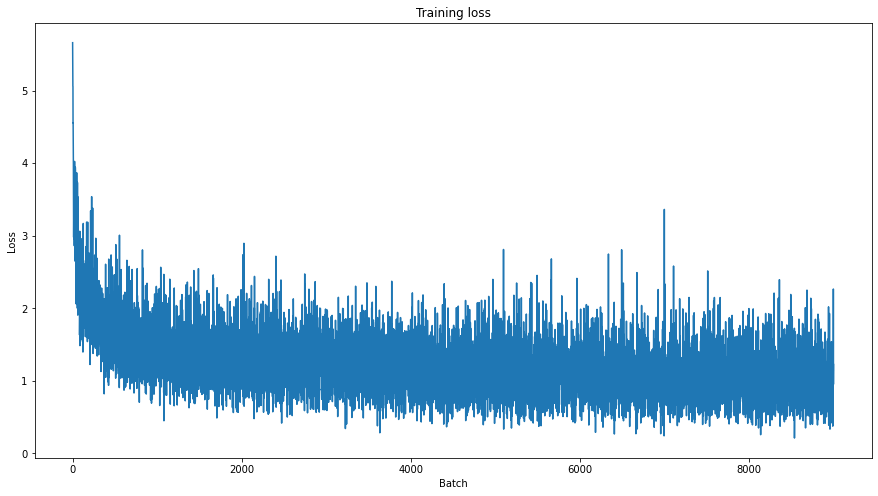

In [41]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

**Load test dataset**

In [42]:
!wget 'https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json'

--2022-01-26 03:56:47--  https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.111.153, 185.199.109.153, 185.199.108.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.111.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4370528 (4.2M) [application/json]
Saving to: ‘dev-v2.0.json.1’

dev-v2.0.json.1     100%[===================>]   4.17M  --.-KB/s    in 0.07s   

2022-01-26 03:56:48 (58.2 MB/s) - ‘dev-v2.0.json.1’ saved [4370528/4370528]



In [43]:
!cp /content/train-v2.0.json /drive/My\ Drive/END3/.
!cp /content/dev-v2.0.json /drive/My\ Drive/END3/.

In [44]:
input_file = '/drive/My Drive/END3/dev-v2.0.json'
val_examples = read_squad_examples(input_file=input_file,
                                is_training=False,
                                version_2_with_negative=True)

In [45]:

doc_stride = 128
max_seq_length = 256
max_query_length = 64
cached_features_file = '/drive/My Drive/END3/cache_validation'

# Cache features for faster loading
if not os.path.exists(cached_features_file):
  features = convert_examples_to_features(examples=val_examples,
                                        tokenizer=tokenizer,
                                        max_seq_length=max_seq_length,
                                        doc_stride=doc_stride,
                                        max_query_length=max_query_length,
                                        is_training=False)
  torch.save(features, cached_features_file)
else:
  features = torch.load(cached_features_file)

In [46]:
# Convert to Tensors and build dataset
all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
all_cls_index = torch.tensor([f.cls_index for f in features], dtype=torch.long)
all_p_mask = torch.tensor([f.p_mask for f in features], dtype=torch.float)

all_example_index = torch.arange(all_input_ids.size(0), dtype=torch.long)
dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,
                        all_example_index, all_cls_index, all_p_mask)

In [47]:
validation_sampler = SequentialSampler(dataset)
validation_dataloader = DataLoader(dataset, sampler=validation_sampler, batch_size=batch_size, drop_last=True)

**Evaluate test dataset**

In [53]:

def evaluate(model, tokenizer):
  print("***** Running evaluation *****")
  print("  Num examples = %d" % len(dataset))
  print("  Batch size = %d" % batch_size)
  all_results = []
  predict_file = '/drive/My Drive/END3//dev-v2.0.json'
  for batch in tqdm(validation_dataloader, desc="Evaluating", miniters=100, mininterval=5.0):
    model.eval()
    batch = tuple(t.to(device) for t in batch)
    with torch.no_grad():
      inputs = {'input_ids':      batch[0],
                'attention_mask': batch[1],
                'token_type_ids': batch[2]
                }
      example_indices = batch[3]
      outputs = model(**inputs)

    for i, example_index in enumerate(example_indices):
      eval_feature = features[example_index.item()]
      unique_id = int(eval_feature.unique_id)

      result = RawResult(unique_id    = unique_id,
                         start_logits = to_list(outputs[0][i]),
                         end_logits   = to_list(outputs[1][i]))
      all_results.append(result)

  # Compute predictions
  output_prediction_file = "/drive/My Drive/END3/predictions.json"
  output_nbest_file = "/drive/My Drive/END3/nbest_predictions.json"
  output_nbest_file = "/drive/My Drive/END3/nbest_predictions.json"
  output_null_log_odds_file = "/drive/My Drive/END3/null_odds.json"
  output_dir = "/drive/My Drive/END3/predict_results"

  write_predictions(val_examples, features, all_results, 10,
                  30, True, output_prediction_file,
                  output_nbest_file, output_null_log_odds_file, False,
                  True, 0.0)

  # Evaluate with the official SQuAD script
  evaluate_options = EVAL_OPTS(data_file=predict_file,
                               pred_file=output_prediction_file,
                               na_prob_file=output_null_log_odds_file,
                               out_image_dir=None)
  results = evaluate_on_squad(evaluate_options)
  return results

In [54]:
results = evaluate(model, tokenizer)

***** Running evaluation *****
  Num examples = 13600
  Batch size = 16


Evaluating: 100%|██████████| 850/850 [02:04<00:00,  6.84it/s]


{
  "exact": 69.82228585867094,
  "f1": 72.9512942236521,
  "total": 11873,
  "HasAns_exact": 64.389338731444,
  "HasAns_f1": 70.65632866353235,
  "HasAns_total": 5928,
  "NoAns_exact": 75.23969722455845,
  "NoAns_f1": 75.23969722455845,
  "NoAns_total": 5945,
  "best_exact": 70.25183188747579,
  "best_exact_thresh": -0.8906183242797852,
  "best_f1": 73.02605276172412,
  "best_f1_thresh": -0.8906183242797852
}


In [55]:
import json
results_json = []
for k in enumerate(results.keys()):
  result_dict = {k[1] : results[k[1]]}
  results_json.append(result_dict)
print(results_json)
with open('results.json', 'w') as f:
  json.dump(results_json, f)

[{'exact': 69.82228585867094}, {'f1': 72.9512942236521}, {'total': 11873}, {'HasAns_exact': 64.389338731444}, {'HasAns_f1': 70.65632866353235}, {'HasAns_total': 5928}, {'NoAns_exact': 75.23969722455845}, {'NoAns_f1': 75.23969722455845}, {'NoAns_total': 5945}, {'best_exact': 70.25183188747579}, {'best_exact_thresh': -0.8906183242797852}, {'best_f1': 73.02605276172412}, {'best_f1_thresh': -0.8906183242797852}]


# Evaluate on any text

In [60]:
output_prediction_file = "/drive/My Drive/END3/predictions.json"
with open(output_prediction_file) as f:
    lines = f.readlines() 

print("Document: ", (" ".join(val_examples[0].__dict__["doc_tokens"])))
print("\n\n")
for index, each in enumerate(val_examples[:10]):
  print(f"Question: {each.question_text} \n Answer(predicted ans): {(lines[index+1].split(':')[1])}")

Document:  The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.



Question: In what country is Normandy located? 
 Answer(predicted ans):  "France",

Question: When were the Normans in Normandy? 
 Answer(predicted ans):  "10th and 11th centuries",

Question: From which countries did the Norse originate? 
 An